# Dogs vs. Cats
The training and testing data of this project is from a kaggle competetion https://www.kaggle.com/competitions/dogs-vs-cats-redux-kernels-edition/overview.\
The goal of this project is to correctly recognise pictures of dogs and cats.

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


Here is doing a variety of transformation for data augmentation such rotate, flip, etc, and normalisation.\
The normalisation means to 

In [49]:
# define transforms
train_transform= transforms.Compose([
    transforms.RandomRotation(10), # rotate +/- 10 degrees
    transforms.RandomHorizontalFlip(p=0.5), # reverse 50% of images
    transforms.Resize(224), # resize shortest side to 224 pixel
    transforms.CenterCrop(224), # crop longest side to 224 pixels at center
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform= transforms.Compose([
    transforms.Resize(224), # resize shortest side to 224 pixel
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [50]:
# Examne the data
import os
from PIL import Image
from IPython.display import display

# Filter harmless warnings
import warnings
warnings.filterwarnings("ignore")

(416, 426)


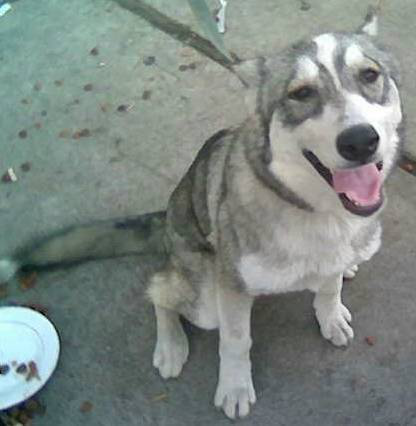

In [51]:
dog = Image.open('./Data/train/dog.7603.jpg')
print(dog.size)
display(dog)

In [52]:
r, g, b = dog.getpixel((0, 0))
print(r,g,b)

103 144 162


torch.Size([3, 426, 416])


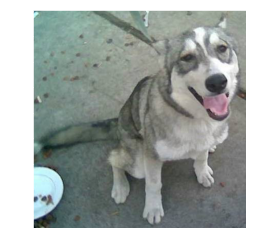

In [53]:
transform = transforms.Compose([
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

Pytorch automatically loads the [0. 255] of range of RGB to [0, 1], so the RGB in the following process is normalised.

In [54]:
im[:,0,0]

tensor([0.4039, 0.5647, 0.6353])

### Transforms
All pictures are not in the same format, so we need to transform them into an apropriate format for further training our model.

torch.Size([3, 229, 224])


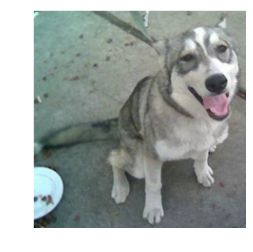

In [55]:
# resize 
transform = transforms.Compose([
    transforms.Resize(224),  # resize shortest side to 224 pixel, this command also works for making small picture bigger
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

torch.Size([3, 224, 224])


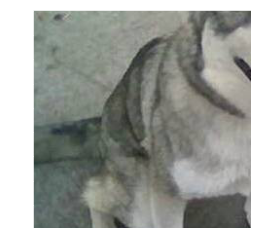

In [56]:
# centercrop
#If size is an integer instead of sequence like (h, w), a square crop of (size, size) is made.

transform = transforms.Compose([
    transforms.CenterCrop(224), 
    transforms.ToTensor()
])
im = transform(dog) # this crops the original image
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

torch.Size([3, 224, 224])


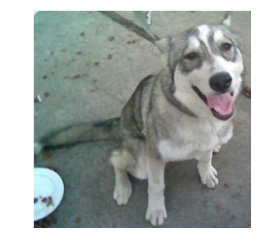

In [57]:
# combine the above two steps
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224), 
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

torch.Size([3, 426, 416])


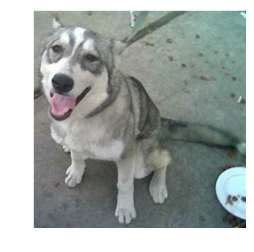

In [58]:
# horizontal flip
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),  # default p=0.5
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

torch.Size([3, 426, 416])


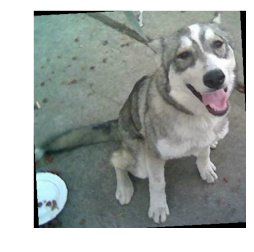

In [59]:
# rotate

transform = transforms.Compose([
    transforms.RandomRotation(30),  # rotate randomly between +/- 30 degrees
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

torch.Size([3, 224, 224])


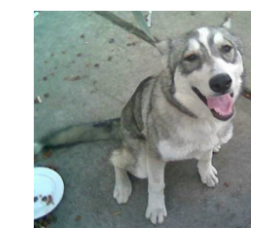

In [60]:
# scaling for different axis can be done by resize

transform = transforms.Compose([
    transforms.Resize((224,224)),  # be sure to pass in a list or a tuple
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

### Normalisation
Once the image is converted in to tensor, we are able to perform normalisation on it. This serve to make convergence happen faster during training. The values are somewhat arbitrary - you can use a mean of 0.5 and a standard deviation of 0.5 to convert a range of [0,1] to [-1,1], for example.<br>However, <a href='https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/22'>research has shown</a> that mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225] work well in practice.

The transformation will be done for each channel of the input tensor as\
$\quad\textrm {input[channel]} = \frac{\textrm{input[channel] - mean[channel]}}{\textrm {std[channel]}}$

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 426, 416])


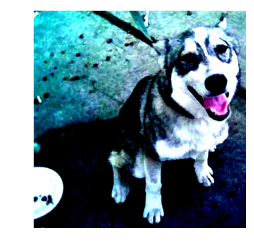

In [61]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [62]:
# After normalization:
im[:,0,0]

tensor([-0.3541,  0.4853,  1.0191])

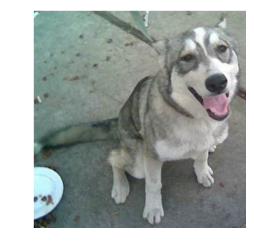

In [63]:
# de-normalisation for seeing the image back

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


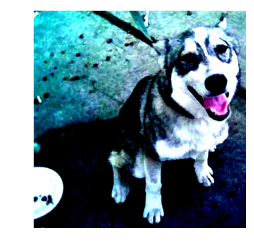

In [64]:
# Note that the original tensor was not modified back

plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

# Define transformation for our project now

In [65]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

# Prepare training set, testing sets, and loaders

In [66]:
from torch.utils.data import Dataset

In [93]:
class FoodDataset(Dataset):
    
    def __init__(self,path,tfm=test_transform,files = None):
        super(FoodDataset).__init__()
        self.path = path
        self.files = sorted([os.path.join(path, x) for x in os.listdir(path) if x.endswith(".jpg")])
        if files != None:
            self.files = files
        print(f"One {path} sample",self.files[0])
        self.transform = tfm
  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)
        #im = self.data[idx]
        try:
            label1 = fname.split("/")[-1].split(".")[0]
            if label1 == 'dog':
                label = 1
            elif label1 == 'cat':
                label = 0
        except:
            label = -1 # test has no label
        return im,label



In [68]:
import shutil
rootdir= './data/original_train' #path of the original folder

os.makedirs(rootdir +'/train/')
os.makedirs(rootdir +'/validation/')
source = rootdir

allFileNames = os.listdir(source)
print(allFileNames[:10])
np.random.shuffle(allFileNames)

FileExistsError: [Errno 17] File exists: './data/original_train/train/'

In [ ]:
val_ratio = 0.2

train_FileNames, val_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)* (1 - val_ratio))])

train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
val_FileNames = [source+'/' + name for name in val_FileNames.tolist()]

In [ ]:
for name in train_FileNames:
    try:
        shutil.copy(name, rootdir +'/train')
    except:
        print(name)

In [ ]:
for name in val_FileNames:
    try:
        shutil.copy(name, rootdir +'/validation')
    except:
        print(name)

In [94]:
batch_size = 64
_dataset_dir = "./data/original_train"
# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = FoodDataset(os.path.join(_dataset_dir,"train"), tfm=train_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_set = FoodDataset(os.path.join(_dataset_dir,"validation"), tfm=test_transform)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

One ./data/original_train/train sample ./data/original_train/train/cat.1.jpg
One ./data/original_train/validation sample ./data/original_train/validation/cat.0.jpg


Label: [1 0 1 0 0 1 0 1 1 1 1 1 0 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0 0 1 1 0 1 1 0 0 1
 1 1 0 0 0 0 1 0 0 1 0 1 1 0 1 1 1 1 0 0 0 0 0 1 1 1 0]


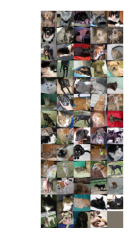

In [95]:
# Grab the first batch of 10 images
for images, labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
# print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

In [99]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(54*54*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

# Training

In [104]:
# This is for the progress bar.
from tqdm.auto import tqdm
import random

_exp_name = "sample"

In [105]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# The number of training epochs and patience.
n_epochs = 4
patience = 300 # If no improvement in 'patience' epochs, early stop

# Initialize a model, and put it on the device specified.
model = CNNClassifier().to(device)

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5) 

In [106]:
# The model training code here is modified based on HW3 CNN of Course "MACHINE LEARNING 2021 SPRING" given by HUNG-YI LEE and his teaching group
# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):

        imgs, labels = batch
        #imgs = imgs.half()
        #print(imgs.shape,labels.shape)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        loss = criterion(logits, labels.to(device))

        # accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # update logs
    if valid_acc > best_acc:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break

  0%|          | 0/313 [00:00<?, ?it/s]

[ Train | 001/004 ] loss = 0.62054, acc = 0.64292


  0%|          | 0/79 [00:00<?, ?it/s]

[ Valid | 001/004 ] loss = 0.58996, acc = 0.67860
[ Valid | 001/004 ] loss = 0.58996, acc = 0.67860 -> best
Best model found at epoch 0, saving model


  0%|          | 0/313 [00:00<?, ?it/s]

[ Train | 002/004 ] loss = 0.54410, acc = 0.71750


  0%|          | 0/79 [00:00<?, ?it/s]

[ Valid | 002/004 ] loss = 0.51821, acc = 0.74842
[ Valid | 002/004 ] loss = 0.51821, acc = 0.74842 -> best
Best model found at epoch 1, saving model


  0%|          | 0/313 [00:00<?, ?it/s]

[ Train | 003/004 ] loss = 0.49618, acc = 0.75389


  0%|          | 0/79 [00:00<?, ?it/s]

[ Valid | 003/004 ] loss = 0.49339, acc = 0.75890
[ Valid | 003/004 ] loss = 0.49339, acc = 0.75890 -> best
Best model found at epoch 2, saving model


  0%|          | 0/313 [00:00<?, ?it/s]

[ Train | 004/004 ] loss = 0.46638, acc = 0.77591


  0%|          | 0/79 [00:00<?, ?it/s]

[ Valid | 004/004 ] loss = 0.49331, acc = 0.75514
[ Valid | 004/004 ] loss = 0.49331, acc = 0.75514


def to_dataframe(file_names):
    files, labels = list(), list()
    for file in file_names:
        files.append(file)
        labels.append(file[:3])
    df = pd.DataFrame({'filename':files, 'label':labels})
    return df